<a href="https://colab.research.google.com/github/AnnaBozhenko/ML_course/blob/master/03_pyTorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


In [2]:
# import clothes dataset
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None)

test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None)

100%|██████████| 26421880/26421880 [00:01<00:00, 16171448.02it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 280297.70it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5043495.17it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20104540.96it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
class_names = train_data.classes
[print(f"{class_names[i]} = {i}") for i in range(len(class_names))]

T-shirt/top = 0
Trouser = 1
Pullover = 2
Dress = 3
Coat = 4
Sandal = 5
Shirt = 6
Sneaker = 7
Bag = 8
Ankle boot = 9


[None, None, None, None, None, None, None, None, None, None]

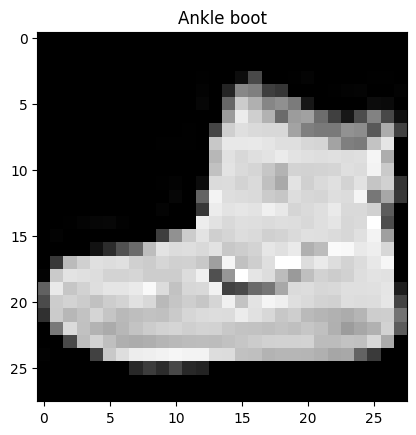

In [4]:
image, train_label = train_data[0]
plt.title(f"{class_names[train_label]}")
plt.imshow(image.squeeze(), cmap="gray")


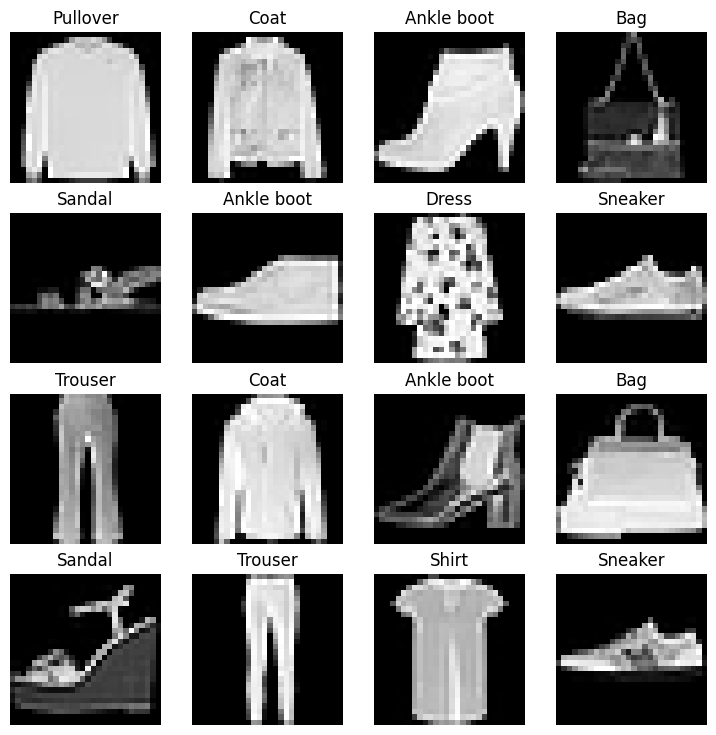

In [5]:
fig = plt.figure(figsize=(9, 9))
rows, columns = 4, 4
for i in range(1, rows * columns + 1):
    item_label_idx = torch.randint(0, len(train_data), size=[1]).item()
    item_image, item_label_idx = train_data[item_label_idx]
    item_label = class_names[item_label_idx]

    fig.add_subplot(rows, columns, i)
    plt.title(item_label)
    plt.imshow(item_image.squeeze(), cmap="gray")
    plt.axis(False)

# Divide training dataset on 32 batches

In [6]:
from torch.utils.data import DataLoader

In [7]:
BATCH_SIZE = 32

In [8]:
train_data_loader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)


In [9]:
test_data_loader = DataLoader(dataset=test_data,
                               batch_size=BATCH_SIZE,
                               shuffle=False)


# Example of a pick from train_data batch

In [10]:
# visualise batch item
train_dataloader_images, train_dataloader_labels_idxs = next(iter(test_data_loader))



(-0.5, 27.5, 27.5, -0.5)

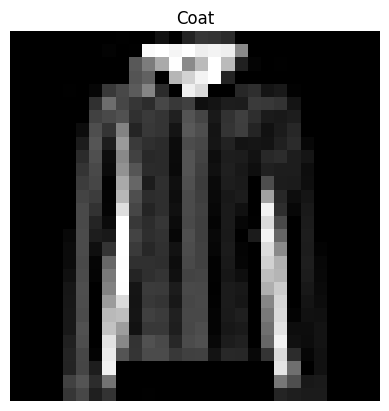

In [11]:
torch.manual_seed(42)

item_idx = torch.randint(0, len(train_dataloader_images), size=[1]).item()
image, label_idx = train_dataloader_images[item_idx], train_dataloader_labels_idxs[item_idx]

plt.title(class_names[label_idx])
plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off")

# Create model

In [12]:
flatten_model = nn.Flatten()

x = train_dataloader_images[0]
output = flatten_model(x)

In [13]:
output.shape

torch.Size([1, 784])

In [14]:
class FashionMNISTModel_V0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.layers(x)


In [15]:
torch.manual_seed(42)

INPUT_FEATURES = 28*28
OUTPUT_FEATURES = len(class_names)
HIDDEN_FEATURES = 10
device_model_0 = "cuda"
model_0 = FashionMNISTModel_V0(input_features=INPUT_FEATURES,
                               output_features=OUTPUT_FEATURES,
                               hidden_units=HIDDEN_FEATURES).to(device_model_0)

In [16]:
model_0

FashionMNISTModel_V0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
# example of forward pass on dummy data
dummy_batch = torch.rand([1, 1, 28, 28]).to(device_model_0)
model_0(dummy_batch)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Setting up loss, optomisation and accuracy functions

In [18]:
from pathlib import Path
import requests

if not Path("helper_functions.py").is_file():
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


In [19]:
from helper_functions import accuracy_fn


In [20]:
loss_fn = nn.CrossEntropyLoss()

optimiser = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
from timeit import default_timer as timer

def measure_process_exec(time_start,
                         time_end,
                         device: torch.device = None):
  exec_time = time_end - time_start
  print(f"execution time: {exec_time:.3f} on device {device}")
  return exec_time

In [22]:
from tqdm.auto import tqdm

In [23]:
epochs_n = 3
start_epoch_n = 0
end_epoch_n = start_epoch_n + epochs_n
test_step = 400

In [24]:
torch.manual_seed(43)

traininig_start_time = timer()

for epoch in tqdm(range(start_epoch_n, end_epoch_n)):
  model_0.train()
  train_loss = 0
  for batch, (X_train, y_train) in enumerate(train_data_loader):
    train_preds = model_0(X_train.to(device_model_0))

    loss = loss_fn(train_preds, y_train.to(device_model_0))
    train_loss += loss

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    if batch % 400 == 0:
      print(f"{batch*len(X_train)}/{len(train_data_loader.dataset)} training data processed")

  train_loss /= len(train_data_loader)

  # test for every other n step
  # if epoch % 10 == 0:
  model_0.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for X_test, y_test in test_data_loader:
      test_preds = model_0(X_test.to(device_model_0))
      loss = loss_fn(test_preds, y_test.to(device_model_0))
      test_loss += loss

      acc = accuracy_fn(y_true=y_test.to(device_model_0),
                        y_pred=test_preds.argmax(dim=1))
      test_acc += acc

    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)

  print(f"train loss: {train_loss:.2f}, test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}%")

traininig_end_time = timer()
training_duration_time = measure_process_exec(time_start=traininig_start_time,
                                              time_end=traininig_end_time,
                                              device=str(next(model_0.parameters()).device))

start_epoch_n = end_epoch_n
end_epoch_n += epochs_n


  0%|          | 0/3 [00:00<?, ?it/s]

0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.59, test loss: 0.51, test accuracy: 82.27%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.47, test loss: 0.49, test accuracy: 82.52%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.45, test loss: 0.51, test accuracy: 82.43%
execution time: 30.565 on device cuda:0


In [42]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  model_0.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device_model_0), y_test.to(device_model_0)

      test_preds = model(X_test)
      loss = loss_fn(test_preds, y_test)
      test_loss += loss

      acc = accuracy_fn(y_true=y_test,
                        y_pred=test_preds.argmax(dim=1))
      test_acc += acc

    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)

  return {"test_loss": test_loss,
          "test_accuracy": test_acc,
          "model_name": model.__class__.__name__}




In [26]:
# setup device-agnostic code
torch.cuda.is_available()

True

In [27]:
!nvidia-smi

Mon May 20 20:41:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0              28W /  70W |    159MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Implement class and functionalize training and testing loop

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
class FashionMNIST_V1(nn.Module):
  def __init__(self,
               input_features,
               output_features,
               hidden_features):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features,
                  out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features,
                  out_features=output_features),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layers(x)



In [30]:
model_1 = FashionMNIST_V1(input_features=28*28,
                          output_features=len(class_names),
                          hidden_features=10).to(device)

Set loss and optimise functions

In [31]:
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.1)

Functionalize training

In [33]:
def train_model(model: nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn: nn.Module = None,
                device: torch.device = device,
                random_seed=43,
                batch_n_step_to_report=400):
  torch.manual_seed(random_seed)

  model.train()
  train_loss, train_accuracy = 0, 0

  for batch, (X_train, y_train) in enumerate(data_loader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    train_preds = model(X_train)
    loss = loss_fn(train_preds, y_train)
    train_loss += loss

    if accuracy_fn is not None:
      train_accuracy += accuracy_fn(y_true=y_train,
                                    y_pred=train_preds.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % batch_n_step_to_report == 0:
      print(f"{batch*len(X_train)}/{len(data_loader.dataset)} training data processed")

  train_loss /= len(data_loader)

  if train_accuracy > 0:
    train_accuracy /= len(data_loader)

  print(f"train loss: {train_loss:.2f}, train accuracy: {train_accuracy:.2f}%")
  return {"train_loss": train_loss,
          "train_accuracy": train_accuracy}


In [36]:
def test_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn,
               device: torch.device = device):
  model.eval()
  test_loss, test_accuracy = 0, 0

  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_preds = model(X_test)
      loss = loss_fn(test_preds, y_test)
      test_loss += loss

      acc = accuracy_fn(y_true=y_test,
                        y_pred=test_preds.argmax(dim=1))
      test_accuracy += acc

    test_loss /= len(data_loader)
    test_accuracy /= len(data_loader)

  print(f"test loss: {test_loss:.2f}, test accuracy: {test_accuracy:.2f}%")
  return {"test_loss": test_loss,
          "test_accuracy": test_accuracy}


training and testing data

In [39]:
from timeit import default_timer as timer

epochs_n = 3
start_training_time = timer()
test_step = 3

In [38]:
device

'cuda'

In [41]:
for epoch in tqdm(range(epochs_n)):
  train_model(model_1,
              train_data_loader,
              loss_fn,
              optimizer,
              accuracy_fn)

  test_model(model_1,
            test_data_loader,
            loss_fn,
            accuracy_fn)

end_training_time = timer()
training_duration = measure_process_exec(time_start=start_training_time,
                                         time_end=end_training_time,
                                         device=str(next(model_0.parameters()).device))

print(f"training duration: {training_duration}")

  0%|          | 0/3 [00:00<?, ?it/s]

0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.68, train accuracy: 74.60%
test loss: 0.70, test accuracy: 73.95%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.66, train accuracy: 74.97%
test loss: 0.70, test accuracy: 74.12%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.65, train accuracy: 75.46%
test loss: 0.69, test accuracy: 74.34%
execution time: 173.349 on device cuda:0
training duration: 173.3488188670001


In [43]:
# evaluate the model
eval_output = eval_model(model_1,
                         test_data_loader,
                         loss_fn,
                         accuracy_fn)

print(eval_output)

{'test_loss': tensor(0.6914, device='cuda:0'), 'test_accuracy': 74.34105431309904, 'model_name': 'FashionMNIST_V1'}
